In [1]:
%matplotlib inline
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import sys
import random
import warnings

import numpy as np

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import *

import tensorflow as tf

from sklearn.metrics import f1_score

#seed = 42
#random.seed = seed
#np.random.seed = seed

C:\Users\Ismail-P51\Anaconda3\envs\ml\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
IMG_HEIGHT = 400
IMG_WIDTH = 400
IMG_CHANNELS = 3

In [3]:
# Helper functions

def load_image(infilename):
    data = imread(infilename)[:,:,:IMG_CHANNELS]
    return data

def load_image_label(infilename):
    data = imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [4]:
# Loaded a set of images
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(400, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image_label(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


In [5]:
imgs[0].shape

(400, 400, 3)

In [6]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [7]:
X_train = np.array(imgs)
Y_train = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for i in range(len(imgs)):
    mask_ = np.expand_dims(gt_imgs[i], axis=-1)
    Y_train[i] = mask_

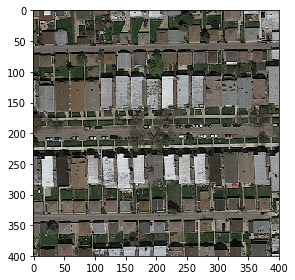

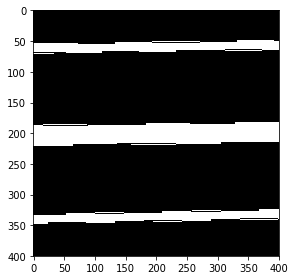

In [8]:
# Check if training data looks all right
ix = random.randint(0, len(imgs) - 1)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [9]:
print(X_train.shape)
print(Y_train.shape)
print(X_train.dtype)
print(Y_train.dtype)

(100, 400, 400, 3)
(100, 400, 400, 1)
uint8
bool


In [10]:
print(len(Y_train[Y_train == True]))

3604158


In [11]:
val_split = 0.1
idx_x = int(X_train.shape[0]*(1.0-val_split))
idx_y = int(Y_train.shape[0]*(1.0-val_split))
X_TR  = X_train[:idx_x]
Y_TR  = Y_train[:idx_y]
X_VAL = X_train[idx_x:]
Y_VAL = Y_train[idx_y:]

In [12]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

reg = 0 #1e-5

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (s)
c1 = Dropout(0.2) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p1)
c2 = Dropout(0.2) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p2)
c3 = Dropout(0.3) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p3)
c4 = Dropout(0.3) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p4)
c5 = Dropout(0.4) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u6)
c6 = Dropout(0.3) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u7)
c7 = Dropout(0.3) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u9)
c9 = Dropout(0.2) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 400, 400, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 400, 400, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=50, 
                    callbacks=[earlystopper, checkpointer])



Train on 90 samples, validate on 10 samples
Epoch 1/50
90/90 [==============================] - 67s 740ms/step - loss: 0.5757 - acc: 0.7481 - val_loss: 0.5866 - val_acc: 0.7488

Epoch 00001: val_loss improved from inf to 0.58658, saving model to model-dsbowl2018-1.h5
Epoch 2/50
90/90 [==============================] - 87s 963ms/step - loss: 0.5353 - acc: 0.7776 - val_loss: 0.5778 - val_acc: 0.7488

Epoch 00002: val_loss improved from 0.58658 to 0.57781, saving model to model-dsbowl2018-1.h5
Epoch 3/50
90/90 [==============================] - 58s 641ms/step - loss: 0.5118 - acc: 0.7776 - val_loss: 0.5708 - val_acc: 0.7488

Epoch 00003: val_loss improved from 0.57781 to 0.57082, saving model to model-dsbowl2018-1.h5
Epoch 4/50
90/90 [==============================] - 55s 615ms/step - loss: 0.4951 - acc: 0.7776 - val_loss: 0.5907 - val_acc: 0.7488

Epoch 00004: val_loss did not improve from 0.57082
Epoch 5/50
90/90 [==============================] - 54s 605ms/step - loss: 0.4724 - acc: 0.

In [ ]:

# Predict on train, val and test
#model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
model = load_model('model-dsbowl2018-1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
preds_train_t[0]

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [ ]:
print(preds_train_t.shape)
print()
print(f1_score(preds_val_t.flatten(), Y_train[int(Y_train.shape[0]*0.9):].flatten(), average="binary"))